In [1]:
import sys
sys.path.append("/workspaces/mlp-playground/")

In [18]:
import os
import jax
import numpy as np

from jax import random
from matplotlib import pyplot as plt

In [3]:
from playground.sim_clr import constants, utils, data_prep

In [4]:
utils.download_pre_trained()

In [5]:
unlabeled_data, train_data_contrast = data_prep.get_stl_dataset(constants.DATASET_PATH)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
parallel_augment = jax.jit(lambda rng, imgs: jax.vmap(data_prep.augment_image)(random.split(rng, imgs.shape[0]), imgs))

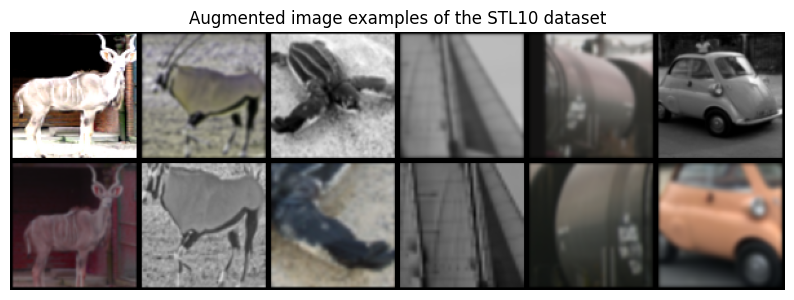

In [19]:
NUM_IMAGES = 6
imgs = np.stack([parallel_augment(random.PRNGKey(idx), np.stack(unlabeled_data[idx][0], axis=0)) for idx in range(NUM_IMAGES)], axis=2)
imgs = (imgs + 1.0) / 2.0
img_grid = np.pad(imgs, ((0,0), (2,2), (0,0), (2,2), (0,0)))
img_grid = img_grid.reshape(img_grid.shape[0]*img_grid.shape[1],-1,img_grid.shape[-1])

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()